# Cadence Modelling

In [106]:
import sys
import random
import pandas as pd
import os
import pathlib
import yaml
import disvoice
import librosa 
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import scipy.stats as stats

from pydub import AudioSegment, silence

# Configure display and plotting options
pd.set_option('display.max_rows', None)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)

# Set WD
try:
    os.chdir('cadence_modelling/')
except:
    print(f'WD: {os.getcwd()}')

# Import prosody features
from disvoice_prosody.prosody import Prosody

# Import configs
with open('/home/ubuntu/configs/config.yaml', 'r') as file:
    inputs = yaml.safe_load(file)

WD: /home/ubuntu/testing-code/cadence-modellling


## Load in data

In [ ]:
# Get resampled real and fake files
data_input_path = '../../data/TIMIT_and_ElevenLabs/TIMIT and ElevenLabs/'

all_wav_files = pathlib.Path(data_input_path)
all_wav_files = list(all_wav_files.rglob("*.wav")) + list(all_wav_files.rglob("*.WAV"))

real_resampled_wav_files = [str(file) for file in all_wav_files if 'real' in str(file)]
fake_resampled_wav_files = [str(file) for file in all_wav_files if 'fake_processed' in str(file)]

In [ ]:
# Load audio data
real_resampled_audios = [librosa.load(file)[0] for file in real_resampled_wav_files]
fake_resampled_audios = [librosa.load(file)[0] for file in fake_resampled_wav_files]

In [ ]:
# Obtain sample rates (assumed same sample rate for all real recordings)
real_sr = [librosa.load(file)[1] for file in real_resampled_wav_files[0:2]][0]
fake_sr = [librosa.load(file)[1] for file in fake_resampled_wav_files[0:2]][0]
print(f'Real sample rate: {real_sr}, fake sample rate: {fake_sr}')

Real sample rate: 22050, fake sample rate: 22050


In [ ]:
test_file = [file for file in real_resampled_wav_files if f'/{phrase}/' in file][0]
test_audio = librosa.load(test_file)[0]

#plt.grid()
#plt.plot(np.arange(len(test_audio)), test_audio)
#plt.title(f"Test audio example IN AMPLITUDE")
#plt.show()

## Automated feature extraction: Disvoice and Pydub
On raw file:

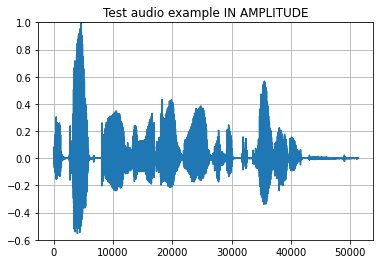

                    0
stddurpause       0.0
skwdurpause       0.0
kurtosisdurpause  0.0
maxdurpause       0.0
mindurpause       0.0
PVU               0.0
PU                0.0
UVU               0.0
VVU               0.0
VP                0.0
UP                0.0


In [ ]:
test_file = [file for file in real_resampled_wav_files if f'/{phrase}/' in file][0]
test_audio = librosa.load(test_file)[0]

prosodyf = Prosody()
sf.write('temp_audio.wav', test_audio, real_sr)
f = prosodyf.extract_features_file('temp_audio.wav', static=True, plots=False, fmt="csv")
print(f.T[92:103])
os.remove('temp_audio.wav')

On augmented file:

0.0


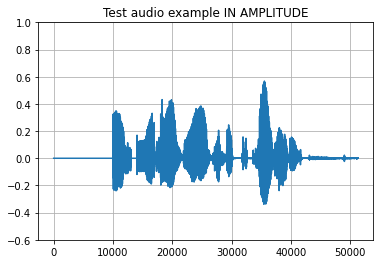

                         0
stddurpause       0.120000
skwdurpause       0.000000
kurtosisdurpause -2.000000
maxdurpause       0.440000
mindurpause       0.200000
PVU               1.382228
PU                3.281860
UVU               0.421172
VVU               0.578828
VP                0.418764
UP                0.304705


In [ ]:
# Same result even with test case 
test_file = [file for file in real_resampled_wav_files if f'/{phrase}/' in file][0]
test_audio = librosa.load(test_file)[0]

print(min(abs(test_audio)))
test_audio[0:10000] = 0.0
test_audio[13000:14000] = 0.0

plt.grid()
plt.plot(np.arange(len(test_audio)), test_audio)
plt.ylim(-0.6, 1)
plt.title(f"Test audio example IN AMPLITUDE")
plt.show()

prosodyf = Prosody()
sf.write('temp_audio.wav', test_audio, real_sr)
f = prosodyf.extract_features_file('temp_audio.wav', static=True, plots=False, fmt="csv")
print(f.T[92:103])
os.remove('temp_audio.wav')

## Tuning input parameters for packages

In [ ]:
test_file = [file for file in real_resampled_wav_files if f'/{phrase}/' in file][0]
test_audio = librosa.load(test_file)[0]

audio = test_audio
audio = librosa.amplitude_to_db(audio)

#plt.grid()
#plt.plot(np.arange(len(audio)), audio)
#plt.title(f"Test audio example IN DB")
#plt.show()

sf.write('temp_audio.wav', audio, real_sr)

aud = AudioSegment.from_wav('temp_audio.wav')
print(silence.detect_silence(aud, min_silence_len=10, silence_thresh=0))

os.remove('temp_audio.wav')

[[0, 3348]]


## Manually extracting pauses vs. voiced components

USNG THRESHOLD: 0.5%
Audio total duration: 2.326394557823129seconds
0.8593650793650793s silent
1.46702947845805s voiced
% pause: 36.939782053531395
% voiced: 63.060217946468605
Ratio of pause to voiced for REAL: 0.5857858291084457


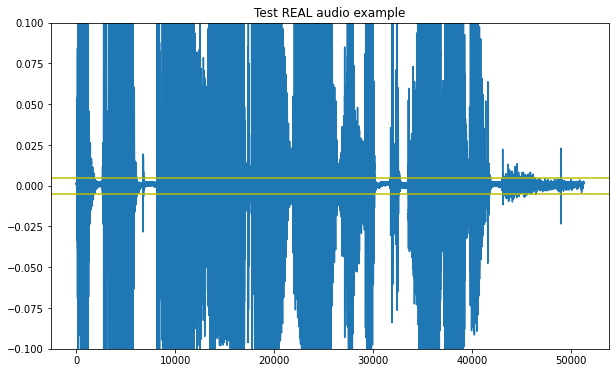

USNG THRESHOLD: 0.5%
Audio total duration: 2.326394557823129seconds
0.3757369614512472s silent
1.9506575963718822s voiced
% pause: 16.151041971265375
% voiced: 83.84895802873463
Ratio of pause to voiced for FAKE: 0.19262066400074399


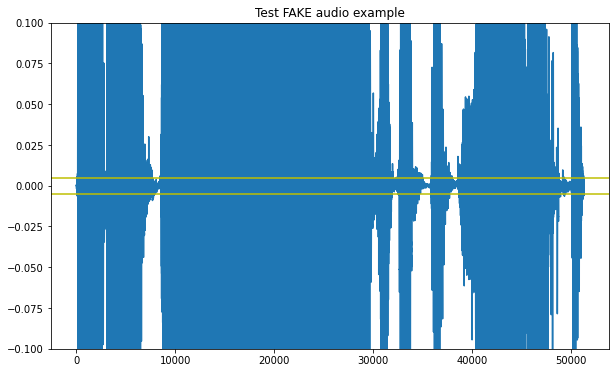

(16.151041971265375, 83.84895802873463, 0.19262066400074399)

In [ ]:
def get_silence(audio, percent, zero_indices=False, label='REAL', plot=True, printout=True):
    #thresh = np.mean(abs(audio))*percent - previous idea - use mean to accoiunt for fake sgenerally being louder?
    thresh = max(abs(audio))*percent

    silent = np.where(abs(audio) < thresh)
    voiced = np.where(abs(audio) >= thresh)
    
    pct_pause = len(silent[0])*100/(len(silent[0])+len(voiced[0]))
    pct_voiced = len(voiced[0])*100/(len(silent[0])+len(voiced[0]))
    ratio_pause_voiced = len(silent[0])/len(voiced[0]) 
    
    if zero_indices:
        audio[silent] = 0 # Set values below threshold to 0

    if printout:
        print(f'USNG THRESHOLD: {percent*100}%')
        print(f'Audio total duration: {len(audio)/real_sr}seconds')
        print(f'{len(silent[0])/real_sr}s silent')
        print(f'{len(voiced[0])/real_sr}s voiced')

        print(f'% pause: {pct_pause}')
        print(f'% voiced: {pct_voiced}')
        print(f'Ratio of pause to voiced for {label}: {ratio_pause_voiced}')

    
    if plot:
        plt.figure(figsize=(10,6))
        plt.plot(np.arange(len(audio)), audio)
        plt.ylim([-0.1, 0.1])
        plt.title(f"Test {label} audio example")

        plt.axhline(y=thresh, color='y')
        plt.axhline(y=-thresh, color='y')

        plt.show()
        
    return pct_pause, pct_voiced, ratio_pause_voiced
    
    
percent = 0.005

phrase = 'SX238'
real_example = [file for file in real_resampled_wav_files if f'/{phrase}/' in file][0]
fake_example = [file for file in fake_resampled_wav_files if f'/{phrase}/' in file][0]


get_silence(librosa.load(real_example)[0], percent, plot=True)
get_silence(librosa.load(fake_example)[0], percent, label='FAKE', plot=True)

## Silence Threshold: Hyperparameter Tuning

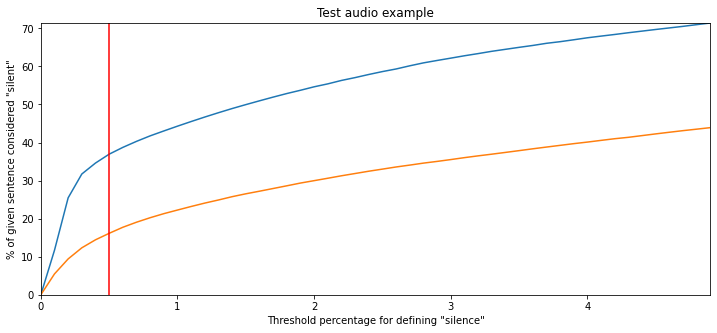

In [ ]:
# Tune as a hyperparameter to find the optimal 'silence' threshold
phrase = 'SX238'
#ns = np.arange(0, 7, 1)
ns = [0]

for n in ns:
    real_example = [file for file in real_resampled_wav_files if f'/{phrase}/' in file][n]
    fake_example = [file for file in fake_resampled_wav_files if f'/{phrase}/' in file][n]

    reals = []
    fakes = []

    range_ = np.arange(0, 0.05, 0.001)

    for i in range_:
        percent = i
        r1, r2, r3 = get_silence(librosa.load(real_example)[0], percent, plot=False, printout=False)
        f1, f2, f3 = get_silence(librosa.load(fake_example)[0], percent, label='FAKE', plot=False, printout=False)
        reals.append(r1)
        fakes.append(f1)

    plt.figure(figsize=(12,5))
    plt.plot(range_*100, reals)
    plt.plot(range_*100, fakes)
    plt.title(f"Test audio example")
    plt.xlabel('Threshold percentage for defining "silence"')
    plt.ylabel('% of given sentence considered "silent"')

    plt.xlim(0, max(range_)*100)
    plt.ylim(0, max(reals))

    plt.axvline(x=0.5, color='r')
    plt.show()

# Silence across audios and phrases 

In [ ]:
# Get rid of folders that contain any wrong files
test_folders = []

for folder in os.listdir(data_input_path):
    phrase_files = [phrase for phrase in real_resampled_wav_files if folder in phrase]
    #phrase_files = [phrase for phrase in real_resampled_wav_files if f'_{folder}.' in phrase]
    #phrase_files = [phrase for phrase in phrase_files if f'/{folder}/' in phrase]
    
    file_names = set([name.split('_')[-1].split('.')[0] for name in phrase_files])
    
    if len(file_names) > 1:
        continue
    
    # Ensure each file has at least 2 real samples
    elif len(phrase_files) > 1:
        test_folders.append(folder)
print(len(test_folders))

149


### Comparison across real vs. fake
Within a single example, we want to plot the spread of real vs. fake:

In [ ]:
# Use test_folder 0 as an example
percent = 0.005

r1s = []
f1s = []

print(f'Params: {len(test_folders)} different phrases')

for n in range(len(test_folders)):
    phrase = test_folders[n]

    real_examples = [file for file in real_resampled_wav_files if f'_{phrase}.' in file]
    real_examples = [file for file in real_examples if f'/{phrase}/' in file]
    
    fake_examples = [file for file in fake_resampled_wav_files if f'_{phrase}.' in file]
    fake_examples = [file for file in fake_examples if f'/{phrase}/' in file]

    for item in real_examples:
        r1, r2, r3 = get_silence(librosa.load(item)[0], percent, plot=False, printout=False)
        r1s.append(r1)

    for item in fake_examples:
        f1, f2, f3 = get_silence(librosa.load(item)[0], percent, plot=False, printout=False)
        f1s.append(f1)
print(f'{len(r1s)}, {len(f1s)}')

Params: 149 different phrases
1043, 1638


In [ ]:
'''
plt.figure(figsize=(12,7))
plt.hist(r1s, alpha=0.5, label=f'Real n={len(r1s)}', bins = 50)
plt.hist(f1s, alpha=0.5, label=f'Fake, n={len(f1s)}', bins = 50)
plt.legend(loc='upper right')
plt.xlabel('% of sentence silent (not voiced)')
plt.ylabel(f'Count (n_files = {len(r1s)+len(f1s)}, n_phrases={len(test_folders)})')
plt.show()
'''

"\nplt.figure(figsize=(12,7))\nplt.hist(r1s, alpha=0.5, label=f'Real n={len(r1s)}', bins = 50)\nplt.hist(f1s, alpha=0.5, label=f'Fake, n={len(f1s)}', bins = 50)\nplt.legend(loc='upper right')\nplt.xlabel('% of sentence silent (not voiced)')\nplt.ylabel(f'Count (n_files = {len(r1s)+len(f1s)}, n_phrases={len(test_folders)})')\nplt.show()\n"

Explore statistical validity:
* Check for normality in both distribtuions
* If normal, perform T test

In [ ]:
stats.ttest_ind(r1s, f1s)

Ttest_indResult(statistic=51.95724264341389, pvalue=0.0)

### Repeat for equal sample numbers of each phrase

In [ ]:
percent = 0.005

r1s = []
f1s = []

real_files = []
fake_files = []

print(f'Params: {len(test_folders)} different phrases')
    
# Temporary: remove duplicate files
file_dict = {}
for i in range(len(real_resampled_wav_files)):
    file_name = real_resampled_wav_files[i].split('/')[-1]
    file_dict[file_name] = real_resampled_wav_files[i]

real_resampled_wav_files = [file_dict[item] for item in file_dict.keys()]
    

for n in range(len(test_folders)):
    phrase = test_folders[n]

    real_examples = [file for file in real_resampled_wav_files if f'_{phrase}.' in file]
    real_examples = [file for file in real_resampled_wav_files if f'/{phrase}/' in file]
    
    fake_examples = [file for file in fake_resampled_wav_files if f'_{phrase}.' in file]
    fake_examples = [file for file in fake_resampled_wav_files if f'/{phrase}/' in file]
    
    # Ensure we take the same number of each phrase for real and fake, downsample the fake files 
    if len(real_examples) > len(fake_examples):
        real_examples = random.sample(real_examples, len(fake_examples))
    else:
        fake_examples = random.sample(fake_examples, len(real_examples))
    
    [real_files.append(file) for file in real_examples]
    [fake_files.append(file) for file in fake_examples]

    for item in real_examples:
        r1, r2, r3 = get_silence(librosa.load(item)[0], percent, plot=False, printout=False)
        r1s.append(r1)

    for item in fake_examples:
        f1, f2, f3 = get_silence(librosa.load(item)[0], percent, plot=False, printout=False)
        f1s.append(f1)
        
print(f'{len(r1s)}, {len(f1s)}')
print(f'{len(real_files)}, {len(fake_files)}')

Params: 149 different phrases
763, 763
763, 763


Ttest_indResult(statistic=38.72798547860952, pvalue=5.119548520073077e-229)



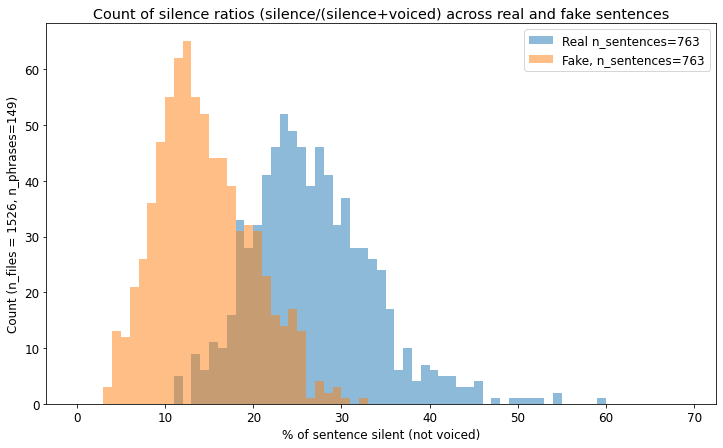

In [ ]:
print(stats.ttest_ind(r1s, f1s))
print()

plt.figure(figsize=(12,7))
plt.hist(r1s, alpha=0.5, label=f'Real n_sentences={len(r1s)}', bins = np.arange(0, 70, 1))
plt.hist(f1s, alpha=0.5, label=f'Fake, n_sentences={len(f1s)}', bins = np.arange(0, 70, 1))
plt.legend(loc='upper right')
plt.xlabel('% of sentence silent (not voiced)')
plt.ylabel(f'Count (n_files = {len(r1s)+len(f1s)}, n_phrases={len(test_folders)})')
plt.title('Count of silence ratios (silence/(silence+voiced) across real and fake sentences')
plt.show()

### Comparison across people
Now, across samples but for the same speaker, we want to plot the spread of pauses.

Try real speakers first:

In [ ]:
# Use test_folder 0 as an example
percent = 0.005

unique_speakers = [file.split('/')[-1].split('_')[0] for file in real_resampled_wav_files] # Each speaker only has 10 phrases though
all_r1s = []

for n in range(len(unique_speakers)):
    speaker = unique_speakers[n]
    r1s_speaker = []

    speaker_examples = [file for file in real_resampled_wav_files if f'/{speaker}_' in file]

    for item in speaker_examples:
        r1, r2, r3 = get_silence(librosa.load(item)[0], percent, plot=False, printout=False)
        r1s_speaker.append(r1)
        
    all_r1s.append(r1s_speaker)
print(f'{len(all_r1s)}')

1958


In [ ]:
'''
plt.figure(figsize=(12,7))
plt.hist(all_r1s[0], alpha=0.5, label=f'Person 1', bins = 5)
plt.hist(all_r1s[200], alpha=0.5, label=f'Person 2', bins = 5)
plt.hist(all_r1s[210], alpha=0.5, label=f'Person 2', bins = 5)
plt.legend(loc='upper right')
plt.xlabel('% of sentence silent (not voiced)')
plt.ylabel(f'Count (n_files = {len(r1s)+len(f1s)}, n_phrases={len(test_folders)})')
plt.show()
'''

"\nplt.figure(figsize=(12,7))\nplt.hist(all_r1s[0], alpha=0.5, label=f'Person 1', bins = 5)\nplt.hist(all_r1s[200], alpha=0.5, label=f'Person 2', bins = 5)\nplt.hist(all_r1s[210], alpha=0.5, label=f'Person 2', bins = 5)\nplt.legend(loc='upper right')\nplt.xlabel('% of sentence silent (not voiced)')\nplt.ylabel(f'Count (n_files = {len(r1s)+len(f1s)}, n_phrases={len(test_folders)})')\nplt.show()\n"

## Which phrases are causing the most separation?

In [ ]:
'''
# SYnch test - make sure all files are aligned within the lists
# Also temporary file-error handling for mis-read files
n_passed = 0
passed_indices = []

for i in range(len(real_files)):
    if real_files[i].split('/')[-1].split('_')[1].split('.')[0] != fake_files[i].split('/')[-1].split('_')[1].split('.')[0]:
        print(f"Failed at index {i} for phrase {real_files[i].split('/')[-1].split('_')[1].split('.')[0]}")
    else:
        n_passed = n_passed + 1
        passed_indices.append(i)
        
print(f'{n_passed} passed out of total {len(real_files)}')

print(f'Previous len real files: {len(real_files)}')
# Temporary: remove duplicate files
file_dict = {}
for i in range(len(real_files)):
    file_name = real_files[i].split('/')[-1]
    file_dict[file_name] = real_files[i]
    
fake_file_dict = {}
for i in range(len(fake_files)):
    file_name = real_files[i].split('/')[-1]
    fake_file_dict[file_name] = fake_files[i]

real_files = [file_dict[item] for item in file_dict.keys()]
print(f'New len real files: {len(real_files)}')
fake_files = [fake_file_dict[item] for item in file_dict.keys()]
print(f'New len fake files: {len(fake_files)}')
'''

'\n# SYnch test - make sure all files are aligned within the lists\n# Also temporary file-error handling for mis-read files\nn_passed = 0\npassed_indices = []\n\nfor i in range(len(real_files)):\n    if real_files[i].split(\'/\')[-1].split(\'_\')[1].split(\'.\')[0] != fake_files[i].split(\'/\')[-1].split(\'_\')[1].split(\'.\')[0]:\n        print(f"Failed at index {i} for phrase {real_files[i].split(\'/\')[-1].split(\'_\')[1].split(\'.\')[0]}")\n    else:\n        n_passed = n_passed + 1\n        passed_indices.append(i)\n        \nprint(f\'{n_passed} passed out of total {len(real_files)}\')\n\nprint(f\'Previous len real files: {len(real_files)}\')\n# Temporary: remove duplicate files\nfile_dict = {}\nfor i in range(len(real_files)):\n    file_name = real_files[i].split(\'/\')[-1]\n    file_dict[file_name] = real_files[i]\n    \nfake_file_dict = {}\nfor i in range(len(fake_files)):\n    file_name = real_files[i].split(\'/\')[-1]\n    fake_file_dict[file_name] = fake_files[i]\n\nreal_fil

In [ ]:
'''
# Check alignment
for i in [0, 10, 100, 50, 98]:
    print(real_files[i])
    print(fake_files[i])
'''

'\n# Check alignment\nfor i in [0, 10, 100, 50, 98]:\n    print(real_files[i])\n    print(fake_files[i])\n'

In [ ]:
agg_r1s = []
agg_f1s = []

for folder in test_folders:
    real_files_folder = [os.path.join(data_input_path, folder, 'real', file) for file in os.listdir(os.path.join(data_input_path, folder, 'real'))]
    fake_files_folder = [os.path.join(data_input_path, folder, 'fake', file) for file in os.listdir(os.path.join(data_input_path, folder, 'fake'))]
    
    r1s_phrases = []
    f1s_phrases = []
    
    for i in range(len(real_files_folder)):
        item = real_files_folder[i]
        r1, r2, r3 = get_silence(librosa.load(item)[0], percent, plot=False, printout=False)
        r1s_phrases.append(r1)

        item = fake_files_folder[i]
        f1, f2, f3 = get_silence(librosa.load(item)[0], percent, plot=False, printout=False)
        f1s_phrases.append(f1)
    
    agg_r1s.append(r1s_phrases)
    agg_f1s.append(f1s_phrases)
    
print(len(agg_r1s))
print(len(agg_f1s))

print(len(agg_r1s[10]))
print(len(agg_f1s[10]))

149
149
7
7


Investigate the top deltas:

In [ ]:
avg_agg_r1s = [np.mean(item) for item in agg_r1s]
avg_agg_f1s = [np.mean(item) for item in agg_f1s]

df = pd.DataFrame({'phrase': test_folders, 'AVG_real_pct_pause': avg_agg_r1s, 'AVG_fake_pct_pause': avg_agg_f1s})
df['delta'] = df['AVG_fake_pct_pause'] - df['AVG_real_pct_pause']
df['abs_delta'] = abs(df['delta'])
df = df.sort_values('abs_delta', ascending=False)
print(df.head())

print()
print(f'Phrases: ')
print(f'{df.iloc[0,0]}: ducks have webbed feet and colorful feathers')
print(f'{df.iloc[1,0]}: bagpipes and bongos are musical instruments')
print(f'{df.iloc[2,0]}: irish youngsters eat fresh kippers for breakfast')
print(f'{df.iloc[3,0]}: smash lightbulbs and their cash value will diminish to nothing')
print(f'{df.iloc[4,0]}: shell shock caused by shrapnel is sometimes cured through group therapy')

    phrase  AVG_real_pct_pause  AVG_fake_pct_pause      delta  abs_delta
40   SX340           37.685272           25.266117 -12.419155  12.419155
107   SX77           28.736654           17.385231 -11.351424  11.351424
21   SX414           36.555658           25.661741 -10.893918  10.893918
148  SX423           28.029599           17.178457 -10.851143  10.851143
19   SX438           31.993370           21.157856 -10.835514  10.835514

Phrases: 
SX340: ducks have webbed feet and colorful feathers
SX77: bagpipes and bongos are musical instruments
SX414: irish youngsters eat fresh kippers for breakfast
SX423: smash lightbulbs and their cash value will diminish to nothing
SX438: shell shock caused by shrapnel is sometimes cured through group therapy


<font color='red'>

# Next:
    
* sliding window of where the pause is the greatest within each sentence
* <b>distribution</b> of silences, not just ratio of silence to voiced 
* biden vs fake biden, obama vs fake obama
* biden vs obama
* autoencoder question
    
One data eng pipeline/dataset 
Youtube upload 
Test mine on all librispeech fakes and see how it transfers - train a one feature classifier 
Test mine on biden and obama 

    
# Other Cadence Ideas
* words per minute
* average speaking rate
* ratio of pauses 

### Shibb ideas:
1. Lung capacity - if we can even just record when you’re likely to take a breath, that might give us a cue into whether its you or not. I put some long phrases into eleven labs to try this and it worked well.
2. Long, and repetitive phrases - when you give eleven labs repetitive phrases, it sounds exactly the same each time. Also, with long phrases, it starts to sound super robotic. Example attached

![SNOWFALL](table.png)

In [ ]:
[file for file in real_files if 'SX340' in file]

[]

NameError: name 'x' is not defined

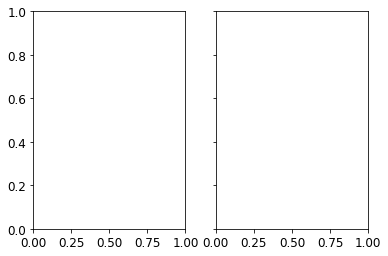

In [ ]:
#fig, ax = plt.subplots()
#ax.plot(x, y)
#ax.set_title('Simple plot')

# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(, y)
ax1.set_title('Sharing Y axis')
ax2.scatter(x, y)

In [ ]:
'''
folder = 'SX340'
[os.path.join(data_input_path, folder, 'real', file) for file in os.listdir(os.path.join(data_input_path, folder, 'real'))]
'''

"\nfolder = 'SX340'\n[os.path.join(data_input_path, folder, 'real', file) for file in os.listdir(os.path.join(data_input_path, folder, 'real'))]\n"

### Check: are results for different aggregation methods consistent?
> Yes

Explore results:

In [ ]:
sum_agg_r1s = [sum(item) for item in agg_r1s]
sum_agg_f1s = [sum(item) for item in agg_f1s]

df = pd.DataFrame({'phrase': test_folders, 'SUM_real_pct_pause': sum_agg_r1s, 'SUM_fake_pct_pause': sum_agg_f1s})
df['delta'] = df['SUM_fake_pct_pause'] - df['SUM_real_pct_pause']
df['abs_delta'] = abs(df['delta'])
df = df.sort_values('abs_delta', ascending=False)
df.head()

,phrase,SUM_real_pct_pause,SUM_fake_pct_pause,delta,abs_delta
19,SX340,411.925625,193.037665,-218.887960,218.887960
64,SX343,352.686043,159.828680,-192.857362,192.857362
17,SX337,372.496778,189.917784,-182.578994,182.578994
43,SX164,318.707483,136.546230,-182.161253,182.161253
24,SX226,334.801290,157.798983,-177.002307,177.002307


## Disvoice Prosody Features

# Failed Experiments

In [ ]:
test_file = real_resampled_wav_files[0]
test_audio = librosa.load(test_file)[0]

#print(min(abs(test_audio)))

#test_audio[0:10000] = 0.0

#test_audio[13000:14000] = 0.0

sf.write('temp_audio.wav', test_audio, real_sr)

f = prosodyf.extract_features_file('temp_audio.wav', static=True, plots=False, fmt="csv")

print(f.T[92:103])

os.remove('temp_audio.wav')


                    0
stddurpause       0.0
skwdurpause       0.0
kurtosisdurpause  0.0
maxdurpause       0.0
mindurpause       0.0
PVU               0.0
PU                0.0
UVU               0.0
VVU               0.0
VP                0.0
UP                0.0


In [ ]:
max(np.array([features[i].loc['maxdurpause'] for i in range(len(features))]))

array([0.])

## PyDub Silence Detector

In [ ]:
from pydub import AudioSegment, silence
#audio = real_resampled_audios[0]
#audio = librosa.amplitude_to_db(audio)
aud = AudioSegment.from_wav(real_resampled_wav_files[0])
print(silence.detect_silence(aud, min_silence_len=10, silence_thresh=16))

[[0, 1353]]


In [ ]:
sf.write('temp_audio.wav', audio, real_sr)

aud = AudioSegment.from_wav('temp_audio.wav')
print(silence.detect_silence(aud, min_silence_len=10, silence_thresh=0))

os.remove('temp_audio.wav')